# Introduction
We are the Computer Science Graduate Student Association at the Univrsity of Oklahoma

Notebooks for this workshop and all future and prior workshops can be found on our [OU DALab github repo](https://github.com/oudalab/databitesp2020)

# Autoencoders

![AEs](https://miro.medium.com/max/3524/1*oUbsOnYKX5DEpMOK3pH_lg.png)

* Neural networks trained to reconstruct the input as the output
* The central hidden layer encodes the input
* The model learns compressed representations of high dimensional data
* Unsupervised learning of complex distributions
* Major components:

    1. Encoder: $E(X): X \rightarrow Z$

    2. Decoder: $D(Z): Z \rightarrow X$
    
    $X$ is the original input 
     
    $Z$ is the encoded representation

* Objective function: min $||X-D(Z)||^2$


# Unsupervised Learning
Only features are available 

Absence of labels or of formal patterns within the data

Extraction of meaningful information or structure, such as :
- learning denoising procedures
- learning manifolds data might lay close to
- clustering data into groups
- estimating probability densities

# Latent Space Representation

![AE Latent Representation](https://static.packt-cdn.com/products/9781789138900/graphics/0d3e8566-e133-4dae-af82-2dc3a2576e63.png)


* Hidden layer of the autoencoder learns useful properties and potentially priotizes features

# Code

In [1]:
!python --version

Python 3.6.9
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [2]:
%pylab inline
import numpy as np
import pandas as pd

from time import time
from imgaug import augmenters as iaa

import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import callbacks, regularizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Layer, Dense, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D

Populating the interactive namespace from numpy and matplotlib


In [3]:
keras.__version__

'2.3.0-tf'

In [6]:
# LOAD DATA
# [Fashon MNIST](https://www.tensorflow.org/tutorials/keras/classification)
(train_x, train_y), (val_x, val_y) = fashion_mnist.load_data()

# BASIC PRE_PROCESS
# Scale data to range [0,1]
train_x = train_x / 255.
val_x = val_x / 255.

# Display data shape
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

For the training set, we have 60000 examples that are 28 by 28 pixel images. 
Each image is labeled with a number from 0 to 9 for a differnt article of clothing.

(60000, 28, 28), (60000,)

For the validation set, we have 10000 examples

(10000, 28, 28), (10000,)

(-0.5, 27.5, 27.5, -0.5)

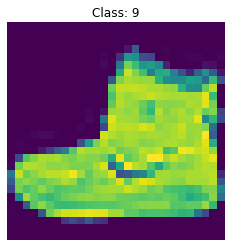

In [7]:
# Display example image
plt.imshow(train_x[0].reshape(28,28))
plt.title('Class: %d' % train_y[0])
plt.axis('off')

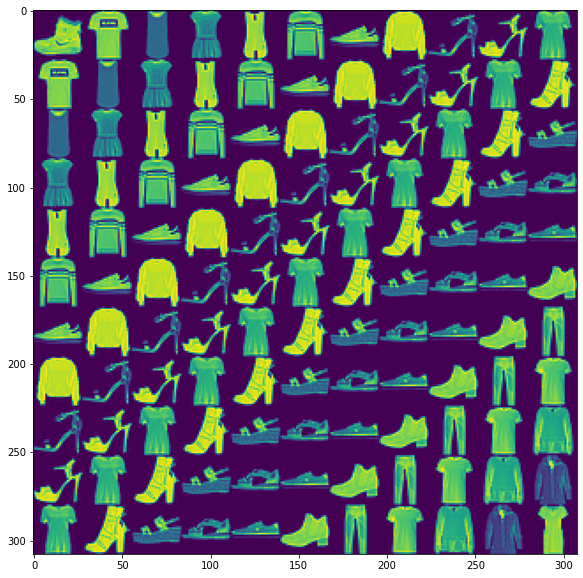

In [8]:
# figure with 11x11 images
n = 11 
img_size = 28
figure = np.zeros((img_size * n, img_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(0, 5, n)
grid_y = np.linspace(0, 5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # Reshape and display example image
        img = train_x[i + j].reshape(28, 28)
        figure[i * img_size: (i + 1) * img_size,
               j * img_size: (j + 1) * img_size] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

Text(0, 0.5, 'classification')

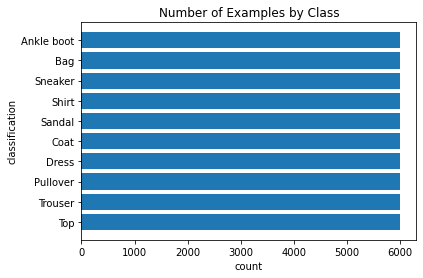

In [9]:
# Get the class labels and the corresponding counts
classes, class_counts = np.unique(train_y, return_counts=True)
class_names = ['Top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# TODO: Bar Plot
plt.barh(class_names, class_counts)
plt.title('Number of Examples by Class')
plt.xlabel('count')
plt.ylabel('classification')

### Basic Neural Network Architecture

1. Input layer
2. Some number of hidden layers
    * each layer has some number of nodes
    * each layer has an activation function
3. Output layer

![Simple NN](https://miro.medium.com/max/1100/1*YgJ6SYO7byjfCmt5uV0PmA.png)

Activation functions, $\phi$, can be anything. Generally, these are nonlinear functions such as sigmoid, tanh, ReLU, and ELU.

![A neuron](https://i.ytimg.com/vi/kft1AJ9WVDk/maxresdefault.jpg)

In [13]:
# RESHAPE DATA INTO VECTOR FORMAT
# The pixels are now rearranged into a single vector instead of a 2D matrix
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

# Display data shape
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((60000, 784), (60000,), (10000, 784), (10000,))

### Traditional Autoencoder
Now that we know a bit about the dataset, let's build an autoencoder to create a compressed representation of our images.

In [14]:
# Input placeholder
input_img = Input(shape=(784,))

# Encoded input representation
l1_out = Dense(2000, activation='relu', name='encoder_L1')(input_img)
l2_out = Dense(500, activation='relu', name='encoder_L2')(l1_out)
l3_out = Dense(500, activation='relu', name='encoder_L3')(l2_out)
latent = Dense(10, activation='sigmoid', name='z')(l3_out)

# Model maps input to an encoded representation
encoder = Model(input_img, latent)


# Lossy reconstruction of the input
l5_out = Dense(500, activation='relu', name='decoder_L1')(latent)
l6_out = Dense(500, activation='relu', name='decoder_L2')(l5_out)
l7_out = Dense(2000, activation='relu', name='decoder_L3')(l6_out)
recon = Dense(784, name='decoder_recon')(l7_out)


# FULL AE MODEL
# Model mapping input to its reconstruction
autoencoder = Model(input_img, recon)

# Display summary of model architecture
autoencoder.summary()

# Compile model
autoencoder.compile(optimizer='adam', loss='mse')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
encoder_L1 (Dense)           (None, 2000)              1570000   
_________________________________________________________________
encoder_L2 (Dense)           (None, 500)               1000500   
_________________________________________________________________
encoder_L3 (Dense)           (None, 500)               250500    
_________________________________________________________________
z (Dense)                    (None, 10)                5010      
_________________________________________________________________
decoder_L1 (Dense)           (None, 500)               5500      
_________________________________________________________________
decoder_L2 (Dense)           (None, 500)               2505

Epoch 1/10
30/30 [==============================] - 33s 1s/step - loss: 0.0912 - val_loss: 0.0684
Epoch 2/10
30/30 [==============================] - 33s 1s/step - loss: 0.0558 - val_loss: 0.0441
Epoch 3/10
30/30 [==============================] - 33s 1s/step - loss: 0.0405 - val_loss: 0.0375
Epoch 4/10
30/30 [==============================] - 33s 1s/step - loss: 0.0356 - val_loss: 0.0327
Epoch 5/10
30/30 [==============================] - 33s 1s/step - loss: 0.0316 - val_loss: 0.0291
Epoch 6/10
30/30 [==============================] - 33s 1s/step - loss: 0.0279 - val_loss: 0.0262
Epoch 7/10
30/30 [==============================] - 33s 1s/step - loss: 0.0252 - val_loss: 0.0244
Epoch 8/10
30/30 [==============================] - 33s 1s/step - loss: 0.0241 - val_loss: 0.0241
Epoch 9/10
30/30 [==============================] - 33s 1s/step - loss: 0.0230 - val_loss: 0.0230
Epoch 10/10
30/30 [==============================] - 33s 1s/step - loss: 0.0224 - val_loss: 0.0216


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 1.0, 'Actual')

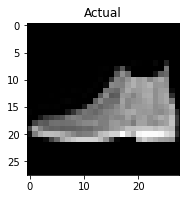

In [16]:
# Keras Callback for early stopping of training
estop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                      patience=10, verbose=1, mode='auto')

# Train the model
train_history = autoencoder.fit(train_x, train_x, epochs=10, batch_size=2048, 
                                validation_data=(val_x, val_x), callbacks=[estop])

# RECONSTRUCTION
# 'Predict' the reconstruction, using the validation set
recon = autoencoder.predict(val_x)

# Compare original output to reconstructed
plt.subplot(1, 2, 1)
plt.imshow(recon[0].reshape(28,28), cmap='gray')
plt.title('Reconstruction')

plt.subplot(1, 2, 2)
plt.imshow(val_x[0].reshape(28,28), cmap='gray')
plt.title('Actual')

Text(0.5, 1.0, 'Actual')

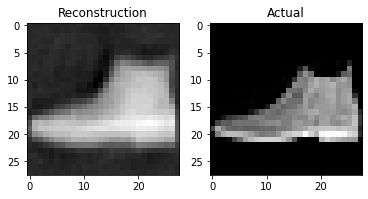

In [18]:
# Compare original output to reconstructed
plt.subplot(1, 2, 1)
plt.imshow(recon[0].reshape(28,28), cmap='gray')
plt.title('Reconstruction')

plt.subplot(1, 2, 2)
plt.imshow(val_x[0].reshape(28,28), cmap='gray')
plt.title('Actual')

### Sparse Autoencoder
Optimize compressed output by reducing the amount of memory using sparse representations instead 

To make representations more compact, impose a sparsity constraint on the activition of the hidden representations (this is the activity 
regularizer in Keras), such that fewer units get activated at a given time

In Keras we use the "activity_regularizer" parameter for each layer to apply penalties on parameters or activations during optimization. 
Penalties are incorporated in the loss function

In [19]:
# Include activity constraint by defining a small value for the activity_regularizer
# ref (https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer)

# Input placeholder
input_img = Input(shape=(784,))

# Encoded input representation
l1_out = Dense(2000, activation='relu', name='encoder_L1')(input_img)
l2_out = Dense(500, activation='relu', name='encoder_L2',
               activity_regularizer=regularizers.l1(10e-10))(l1_out)
l3_out = Dense(500, activation='relu', name='encoder_L3',
               activity_regularizer=regularizers.l1(10e-10))(l2_out)
latent = Dense(10, activation='sigmoid', name='z',
               activity_regularizer=regularizers.l1(10e-10))(l3_out)

# Model maps input to an encoded representation
sparse_encoder = Model(input_img, latent)


# Lossy reconstruction of the input
l5_out = Dense(500, activation='relu', name='decoder_L1')(latent)
l6_out = Dense(500, activation='relu', name='decoder_L2')(l5_out)
l7_out = Dense(2000, activation='relu', name='decoder_L3')(l6_out)
sparse_recon = Dense(784)(l7_out)

# Model mapping latent representation to input reconstruction
#sparse_decoder = Model(encoded, decoded)

# Model mapping input to its reconstruction
sparse_autoencoder = Model(input_img, sparse_recon)

# Display summary of model architecture
sparse_autoencoder.summary()

# Compile model
sparse_autoencoder.compile(optimizer='adam', loss='mse')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
encoder_L1 (Dense)           (None, 2000)              1570000   
_________________________________________________________________
encoder_L2 (Dense)           (None, 500)               1000500   
_________________________________________________________________
encoder_L3 (Dense)           (None, 500)               250500    
_________________________________________________________________
z (Dense)                    (None, 10)                5010      
_________________________________________________________________
decoder_L1 (Dense)           (None, 500)               5500      
_________________________________________________________________
decoder_L2 (Dense)           (None, 500)               2505

Epoch 1/10
30/30 [==============================] - 33s 1s/step - loss: 0.0909 - val_loss: 0.0711
Epoch 2/10
30/30 [==============================] - 33s 1s/step - loss: 0.0636 - val_loss: 0.0518
Epoch 3/10
30/30 [==============================] - 33s 1s/step - loss: 0.0446 - val_loss: 0.0391
Epoch 4/10
30/30 [==============================] - 33s 1s/step - loss: 0.0365 - val_loss: 0.0329
Epoch 5/10
30/30 [==============================] - 33s 1s/step - loss: 0.0319 - val_loss: 0.0298
Epoch 6/10
30/30 [==============================] - 33s 1s/step - loss: 0.0290 - val_loss: 0.0272
Epoch 7/10
30/30 [==============================] - 37s 1s/step - loss: 0.0262 - val_loss: 0.0260
Epoch 8/10
30/30 [==============================] - 33s 1s/step - loss: 0.0247 - val_loss: 0.0238
Epoch 9/10
30/30 [==============================] - 33s 1s/step - loss: 0.0236 - val_loss: 0.0229
Epoch 10/10
30/30 [==============================] - 33s 1s/step - loss: 0.0224 - val_loss: 0.0226
Elapsed Time: 5.79 

Text(0.5, 1.0, 'Actual')

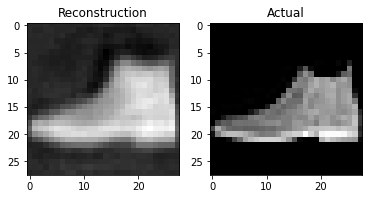

In [20]:
# Train the model
t0 = time()
train_history = sparse_autoencoder.fit(train_x, train_x, 
                                       epochs=10, 
                                       batch_size=2048,
                                       validation_data=(val_x, val_x))
t1 = time()
duration = (t1 - t0) / 60 # convert to minutes
print('Elapsed Time: %.02f min' % duration)



# RECONSTRUCTION
recon_x = sparse_autoencoder.predict(val_x)

# Compare original output to reconstructed
plt.subplot(1, 2, 1)
plt.imshow(recon_x[0].reshape(28, 28), cmap='gray')
plt.title('Reconstruction')

plt.subplot(1, 2, 2)
plt.imshow(val_x[0].reshape(28, 28), cmap='gray')
plt.title('Actual')

### Denoising AutoEncoders
When an image gets corrupted, or contains noise, there is no straight-forward way to remove the noise. 

We want to "denoise" the image and convert the noisy image into a somewhat clearer image with most (or all) of the noise removed.

Example from a simple model:

![Denoising](https://drive.google.com/uc?id=12W8w9c-CtUIl7UeWRmFrY5E9Cw1qD_pk)

In [0]:
# LOAD DATA
(train_x, train_y), (val_x, val_y) = fashion_mnist.load_data()

# Introduce noise to some of the data
# NOTE: In reality we don't know the source or structure of the noise
seq = iaa.Sequential([iaa.SaltAndPepper(.2)])

train_x_aug = seq.augment_images(train_x)
val_x_aug = seq.augment_images(val_x)

In [23]:
# PRE_PROCESS THE DATA
train_x = train_x / 255.
val_x = val_x / 255.

train_x_aug = train_x_aug / 255.
val_x_aug = val_x_aug / 255.

# RESHAPE data into tensors for convolutional network
train_x_img = train_x.reshape(-1, 28, 28, 1)
val_x_img = val_x.reshape(-1, 28, 28, 1)

train_x_aug_img = train_x_aug.reshape(-1, 28, 28, 1)
val_x_aug_img = val_x_aug.reshape(-1, 28, 28, 1)

train_x_img.shape, train_y.shape, val_x_img.shape, val_y.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

#### Convolutional Neural Network

Similar structure to a basic neural network
1. Input layer
2. Some number of hidden layers
    * convolution 
    * max or mean pooling 
    * activation function
    * fully connected dense layers
3. Output layer

![CNN](https://adeshpande3.github.io/assets/Cover.png)

In [25]:
# Input placeholder
input_img = Input(shape=(28, 28, 1))

# Encoded input representation
# padding=same: zero padding during convolution and pooling
# padding=valid: no padding during convolution and pooling
l1_out = Conv2D(64, (3, 3), activation='relu', padding='same', 
                name='encoder_L1_conv2d')(input_img)
l1_out = MaxPool2D((2, 2), padding='same', name='encoder_L1_max')(l1_out)

l2_out = Conv2D(32, (3, 3), activation='relu', padding='same', 
                name='encoder_L2_conv2d')(l1_out)
l2_out = MaxPool2D((2, 2), padding='same', name='encoder_L2_max')(l2_out)

l3_out = Conv2D(16, (3, 3), activation='relu', padding='same', 
                name='encoder_L3_conv2d')(l2_out)
l3_out = MaxPool2D((2, 2), padding='same', name='encoder_L3_max')(l3_out)

# Model mapping input to its encoded representation
denoise_encoder = Model(input_img, l3_out)



# Lossy reconstruction of the input
l4_out = Conv2D(16, (3, 3), activation='relu', padding='same',
                name='decoder_L1_conv2d')(l3_out)
l4_out = UpSampling2D((2, 2), name='decoder_L1_up')(l4_out)

l5_out = Conv2D(32, (3, 3), activation='relu', padding='same',
                name='decoder_L2_conv2d')(l4_out)
l5_out = UpSampling2D((2, 2), name='decoder_L2_up')(l5_out)

l6_out = Conv2D(64, (3, 3), activation='relu',
                name='decoder_L3_conv2d')(l5_out)
l6_out = UpSampling2D((2, 2), name='decoder_L3_up')(l6_out)

recon = Conv2D(1, (3, 3), padding='same', name='decoder_recon')(l6_out)


# FULL AUTOENCODER
# Model mapping input to its reconstruction
denoise_autoencoder = Model(input_img, recon)

# Display Summary
denoise_autoencoder.summary()

# Compile model
denoise_autoencoder.compile(optimizer='adam', loss='mse')

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_L1_conv2d (Conv2D)   (None, 28, 28, 64)        640       
_________________________________________________________________
encoder_L1_max (MaxPooling2D (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_L2_conv2d (Conv2D)   (None, 14, 14, 32)        18464     
_________________________________________________________________
encoder_L2_max (MaxPooling2D (None, 7, 7, 32)          0         
_________________________________________________________________
encoder_L3_conv2d (Conv2D)   (None, 7, 7, 16)          4624      
_________________________________________________________________
encoder_L3_max (MaxPooling2D (None, 4, 4, 16)          0   

Epoch 1/10
20/20 [==============================] - 82s 4s/step - loss: 6.0802e-05 - val_loss: 0.2059
Epoch 2/10
20/20 [==============================] - 82s 4s/step - loss: 3.1814e-06 - val_loss: 0.2057
Epoch 3/10
20/20 [==============================] - 85s 4s/step - loss: 1.8662e-06 - val_loss: 0.2058
Epoch 4/10
20/20 [==============================] - 83s 4s/step - loss: 1.5750e-06 - val_loss: 0.2058
Epoch 5/10
20/20 [==============================] - 82s 4s/step - loss: 1.4229e-06 - val_loss: 0.2058
Epoch 6/10
20/20 [==============================] - 82s 4s/step - loss: 1.3095e-06 - val_loss: 0.2057
Epoch 7/10
20/20 [==============================] - 82s 4s/step - loss: 1.2159e-06 - val_loss: 0.2057
Epoch 8/10
20/20 [==============================] - 82s 4s/step - loss: 1.1437e-06 - val_loss: 0.2057
Epoch 9/10
20/20 [==============================] - 81s 4s/step - loss: 1.0893e-06 - val_loss: 0.2056
Epoch 10/10
20/20 [==============================] - 84s 4s/step - loss: 1.0459e-0

Text(0.5, 1.0, 'Noisy')

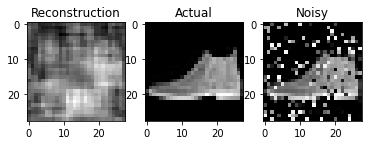

In [26]:
# Train the model
# NOTE: Noisy image is the input; try to reconstruct the original denoised image
# Select subset of data to speed up learning
x_in = train_x_aug_img[:20000]
x_out = train_x_img[:20000]
val_x_in = val_x_aug_img[:5000]
val_x_out = val_x_img[:5000]

train_history = denoise_autoencoder.fit(x_in, x_out, epochs=10, batch_size=1024,
                                        validation_data=(val_x_in, val_x_out))


# RECONSTRUCTION
denoised_x = denoise_autoencoder.predict(val_x_aug_img)

# Compare reconstruction to the original input and the noisy input
plt.subplot(1, 3, 1)
plt.imshow(denoised_x[0].reshape(28, 28), cmap='gray')
plt.title('Reconstruction')

plt.subplot(1, 3, 2)
plt.imshow(val_x[0].reshape(28, 28), cmap='gray')
plt.title('Actual')

plt.subplot(1, 3, 3)
plt.imshow(val_x_aug[0].reshape(28, 28), cmap='gray')
plt.title('Noisy')

### Variational AutoEncoders
Image Generation with Variational AutoEncoders

Main distinction between traditional autoencoders and variational autoencoders is that instead of a compressed bottleneck of information, we attempt to model th probability distribution of the training 
data. 

Generally, from the mean and standard deviation of the data, we can approximate the properties of the population. (Note: the modeled central tendency does not have to be the mean, and the spread does not have to be the standard deviation)

VAEs learn stochastic/probabilitic mappings between the input space and latent space

In this tutorial, the population represents all images that can be in the category of class of training data.

Latent Space: if assumed to have Gayssian distribution, it's parameters are mean, and standard deviation
![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/08/Line-Plot-of-Events-vs-Probability-or-the-Probability-Density-Function-for-the-Normal-Distribution.png)

![VAE](https://drive.google.com/uc?id=1HdsZ-0xL7iBBLNbchJk8xb9S8PhSqQI8)

![VAE](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/06/1_Y49K5UhSMzB3TcA2FKzPMQ.png)

Variational Autoencoder loss considers two things:
1. The negative log likelihood of the output
$$-E_{z \approx q_\theta(z|x_i)} [log (p_\phi (x_i|z))]$$

2. Kullback-Leibler Divergence (KLD) of the "actual" (i.e. the prior) distribution and the predicted distribution. 
    * KLD is a metric describing the difference between two distributions
    $$KL(q_\phi (z|x_i) || p(z)) = q_\phi (z|x_i) * log(\frac{q_\phi (z|x_i)}{p(z)})$$

Combining parts (1) and (2) to construct our loss function:
$$loss = l_i(\theta, \phi)=-E_{z \approx q_\theta(z|x_i)} [log (p_\phi (x_i|z))] + KL(q_\phi (z|x_i) || p(z))$$

In [0]:
# LOAD DATA
(train_x, train_y), (val_x, val_y) = fashion_mnist.load_data()
train_x.shape, train_y.shape, val_x.shape, val_y.shape

In [28]:
# PRE-PROCESS DATA
train_x = train_x / 255.
val_x = val_x / 255.

# VECTORIZE DATA
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [30]:
# Input placeholder
input_img = Input(shape=(784,))

# Encoded input representation
l1_out = Dense(500, activation='relu', name='encoder_L1')(input_img)
z_mu = Dense(10, name='z_mu')(l1_out)
z_log_sigma = Dense(10, name='z_log_sigma')(l1_out)


# Define layer to incorporate KL divergence into the training loss
class KLDLayer(Layer):
    """
    Layer designed to incorporate the loss associated with the 
    latent space distribution
    """
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDLayer, self).__init__(*args, **kwargs)
    def call(self, inputs):
        mu, log_sigma = inputs
        kl_batch = -.5 * K.sum(1 + log_sigma -
                               K.square(mu) - 
                               K.exp(log_sigma), axis=-1)
        kl_loss = K.mean(kl_batch)
        self.add_loss(kl_loss, inputs=inputs)
        return inputs

# Define function for sampling in the latent space
def sampling(args):
    """
    PARAMS:
        args = (z_mean, z_log_var)
            z_mean (tensor): mean of the latent space
            z_log_var (tensor): log of the variance of the latent space
    RETURN:
        z (tensor): a sample from the latent space
    """
    z_mu, z_log_var = args
    batch_size = K.shape(z_mu)[0]
    latent_dim = K.int_shape(z_mu)[1]
    epsilon = K.random_normal(shape=(batch_size, latent_dim))
    return z_mu + K.exp(.5 * z_log_var) * epsilon


# Create the KLD layer for the model
z_mu, z_log_sigma = KLDLayer()([z_mu, z_log_sigma])

# Sample from the latent space distribution
z = Lambda(sampling, output_shape=(10,))([z_mu, z_log_sigma])

# Model mapping to input representation (i.e. the encoder)
v_encoder = Model(input_img, z)


# Model mapping input to its reconstruction
v_decoder = Sequential([
                        Dense(500, input_dim=10, activation='relu', name='decoder_L1'),
                        Dense(784, activation='sigmoid', name='decoder_recon')
])
recon = v_decoder(z)


# Model mapping an input to its reconstruction
vae = Model(input_img, recon)

# Display model summary
vae.summary()

# Function to compute the negative log likelihood
def nll(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

# Compile model
vae.compile(optimizer='adam', loss=nll)

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder_L1 (Dense)              (None, 500)          392500      input_6[0][0]                    
__________________________________________________________________________________________________
z_mu (Dense)                    (None, 10)           5010        encoder_L1[0][0]                 
__________________________________________________________________________________________________
z_log_sigma (Dense)             (None, 10)           5010        encoder_L1[0][0]                 
___________________________________________________________________________________________

Epoch 1/10
30/30 [==============================] - 6s 205ms/step - loss: 422.9872 - val_loss: 340.3145
Epoch 2/10
30/30 [==============================] - 6s 198ms/step - loss: 316.8340 - val_loss: 302.8447
Epoch 3/10
30/30 [==============================] - 6s 200ms/step - loss: 291.3113 - val_loss: 285.5417
Epoch 4/10
30/30 [==============================] - 6s 194ms/step - loss: 278.4199 - val_loss: 275.4229
Epoch 5/10
30/30 [==============================] - 6s 195ms/step - loss: 271.0486 - val_loss: 278.0854
Epoch 6/10
30/30 [==============================] - 6s 196ms/step - loss: 268.2565 - val_loss: 267.1371
Epoch 7/10
30/30 [==============================] - 6s 195ms/step - loss: 263.7578 - val_loss: 264.0969
Epoch 8/10
30/30 [==============================] - 6s 193ms/step - loss: 261.3427 - val_loss: 261.8710
Epoch 9/10
30/30 [==============================] - 6s 192ms/step - loss: 259.5547 - val_loss: 260.1351
Epoch 10/10
30/30 [==============================] - 6s 196ms/st

Text(0.5, 1.0, 'Actual')

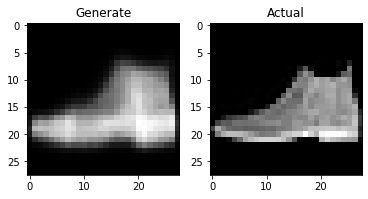

In [31]:
# Train the model to generate images
train_history = vae.fit(train_x, train_x, epochs=10, batch_size=2048, 
                        validation_data=(val_x, val_x))

# Generation
gen = vae.predict(val_x)

# Compare the model output to the original
plt.subplot(1, 2, 1)
plt.imshow(gen[0].reshape(28, 28), cmap='gray')
plt.title('Generate')

plt.subplot(1, 2, 2)
plt.imshow(val_x[0].reshape(28, 28), cmap='gray')
plt.title('Actual')

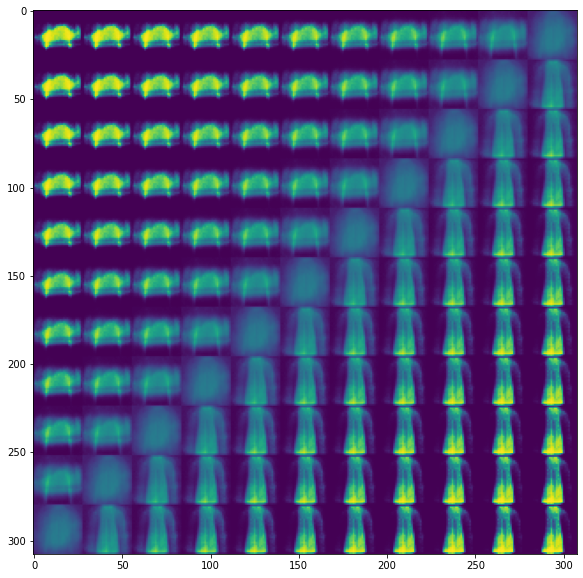

In [35]:
# DISPLAY LINEAR INTERPOLATION IN THE LATENT SPACE
n = 11  # figure with 11x11 imgs
img_size = 28
figure = np.zeros((img_size * n, img_size * n))
# we will sample n points within [-11, 11] standard deviations
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.repeat(np.array([[xi + yi]]), 10, axis=1)
        x_decoded = v_decoder.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size)
        figure[i * img_size: (i + 1) * img_size,
               j * img_size: (j + 1) * img_size] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

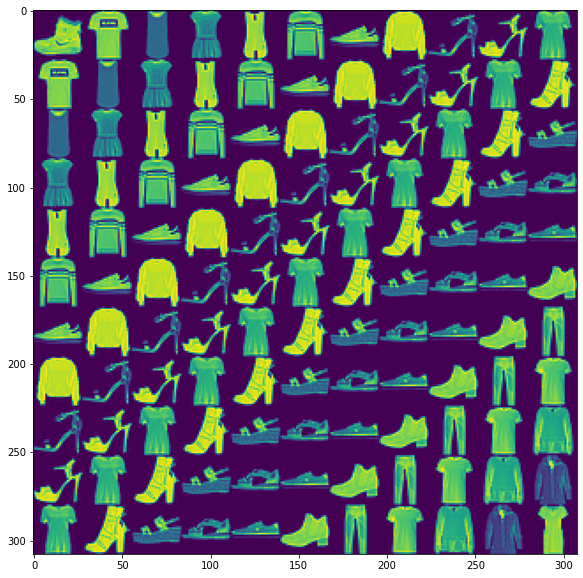

In [33]:
# DISPLAY LINEAR INTERPOLATION IN THE LATENT SPACE
n = 11  # figure with 11x11 imgs
img_size = 28
figure = np.zeros((img_size * n, img_size * n))
# we will sample n points within [-11, 11] standard deviations
grid_x = np.linspace(0, 5, n)
grid_y = np.linspace(0, 5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # Display example image
        img = train_x[i + j].reshape(28,28)
        #plt.title('Class: %d' % train_y[0])
        figure[i * img_size: (i + 1) * img_size,
               j * img_size: (j + 1) * img_size] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# THANK YOU from OU's CSGSA

If you went through the tutorial please complete this brief [sign in form](https://forms.office.com/Pages/ResponsePage.aspx?id=neB9nDSQwUS0YsRk_s4gShSiFd0SB9NPmtonqJ4UHH1UMVBTS1BDOElEMkM1U09FSE9HMzM0Rkw4TiQlQCN0PWcu)

Facebook 
[@oucsgsa](https://www.facebook.com/oucsgsa/?ref=page_internal)

![fb_tag](https://drive.google.com/uc?id=13Ph4OnbDWNqd1nXoSfCykCSQXVy_SEIm)

Instagram

![insta_tag](https://drive.google.com/uc?id=1_ZXNZMqEyB-LfDLnhVTeiS1-2ywih4BR)
